# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig
from torchvision import datasets, transforms
from torchvision import transforms
import os

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
# upload images to s3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(bucket)




sagemaker-us-east-1-722116367570


In [3]:
prefix = "dogImages"
# inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
inputs = "https://sagemaker-us-east-1-722116367570.s3.amazonaws.com/dogImages/"
print("input spec (in this case, just an S3 path): {}".format(inputs))


input spec (in this case, just an S3 path): https://sagemaker-us-east-1-722116367570.s3.amazonaws.com/dogImages/


In [3]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=2,
    instance_type="ml.c5.2xlarge",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [3]:
# location of training, test and validation data
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
# where model will be stored
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/" 
print(os.environ["SM_CHANNEL_TRAINING"])

s3://sagemaker-us-east-1-722116367570/dogImages/


In [4]:
# fit the tiner to find the best values for learning rate and batch size
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [10]:
# run this cell if the session is disconnected and you don't want to rerun the tuning job but rather recover it from the file 
tuner = HyperparameterTuner.attach("pytorch-training-230430-1926")


In [11]:
# grab the opetimal values for learning rate and batch size
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-30 20:06:51 Starting - Preparing the instances for training
2023-04-30 20:06:51 Downloading - Downloading input data
2023-04-30 20:06:51 Training - Training image download completed. Training in progress.
2023-04-30 20:06:51 Uploading - Uploading generated training model
2023-04-30 20:06:51 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.004528688040341531',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-30-19-26-46-633"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-04-30-19-26-46-633/source/sourcedir.tar.gz"'}

In [8]:
# store the optimal values so it can be used in training without a need to retrain the tuner
hyperparameter_optimal_values = {
 'batch-size': '"32"',
 'lr': '0.004528688040341531'
}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [5]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import smdebug.pytorch as smd
from sagemaker.debugger import Rule, rule_configs
from sagemaker.debugger import DebuggerHookConfig


# we will be tracking overfitting, overtraining and poor weight initialization
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

# set the interval for tracking the training progress
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "1"}
)

# set the interval for tracking the training progress
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


[2023-05-01 01:02:41.896 ip-172-16-164-86.ec2.internal:8695 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-01 01:02:42.109 ip-172-16-164-86.ec2.internal:8695 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [10]:
# setup the training job

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.c5.2xlarge",
    entry_point="train_model.py",
    framework_version="1.11.0",
    py_version="py38",
    hyperparameters=hyperparameter_optimal_values,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config,
    rules=rules,
)

estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)

session = boto3.session.Session()
region = session.region_name


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-05-01-01-07-11-108


2023-05-01 01:07:13 Starting - Starting the training job...
2023-05-01 01:07:41 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
...
2023-05-01 01:08:21 Downloading - Downloading input data......
2023-05-01 01:09:21 Training - Downloading the training image...
2023-05-01 01:09:42 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-30 21:09:36,801 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-30 21:09:36,803 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-30 21:09:36,805 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-04-30 21:09:36,815 sagemaker_pytorch_container.training INFO     Block until all host DNS

In [2]:
# recover estimator so the previous steps not need to be rerun each time
estimator = PyTorch.attach("pytorch-training-230430-1926-004-3d5d0fb9")




2023-04-30 20:13:23 Starting - Preparing the instances for training
2023-04-30 20:13:23 Downloading - Downloading input data
2023-04-30 20:13:23 Training - Training image download completed. Training in progress.
2023-04-30 20:13:23 Uploading - Uploading generated training model
2023-04-30 20:13:23 Completed - Resource released due to keep alive period expiry


In [3]:
from smdebug.trials import create_trial

# create the Trial object to access information on the training job
#print(estimator.latest_job_debugger_artifacts_path())
debug_output= "s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-01-01-07-11-108/debug-output/"
trial = create_trial(debug_output)

[2023-05-02 16:19:34.622 ip-172-16-178-41.ec2.internal:3298 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-02 16:19:34.634 ip-172-16-178-41.ec2.internal:3298 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-01-01-07-11-108/debug-output/
[2023-05-02 16:19:35.455 ip-172-16-178-41.ec2.internal:3298 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-01-01-07-11-108/debug-output/index/000000000/000000000076_worker_0.json . Will retry now


In [4]:
from smdebug.core.modes import ModeKeys

trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)

[2023-05-02 16:19:59.684 ip-172-16-178-41.ec2.internal:3298 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-05-02 16:20:00.707 ip-172-16-178-41.ec2.internal:3298 INFO trial.py:210] Loaded all steps


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [6]:

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {boto3.session.Session().region_name}")

Training jobname: pytorch-training-230430-1926-004-3d5d0fb9
Region: us-east-1


In [7]:
# Create Training Wrapper to retrieve profiling on the Training Job
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(training_job_name, boto3.session.Session().region_name)
# used when the job it's not compelete yet and we need to watch how it progress
#tj.wait_for_sys_profiling_data_to_be_available()

KeyboardInterrupt: 

In [ ]:
# retrieve the profiling metrics from the Training Job and plot it in a Graph to facilitate the analysis
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


In [18]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

INFO:matplotlib.font_manager:generated new fontManager


In [19]:
# Check Training Performance
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()

if not debug_artifacts_path:
    debug_artifacts_path = 's3://sagemaker-us-east-1-722116367570/pytorch-training-2023-04-30-17-25-56-149/debug-output'

trial = create_trial(debug_artifacts_path)

[2023-05-01 01:54:05.237 ip-172-16-164-86.ec2.internal:8695 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-01-01-07-11-108/debug-output


In [20]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

In [21]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-VanishingGradient-601c6572',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 5, 1, 1, 49, 57, 992000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-Overfit-12bd4a4e',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 5, 1, 1, 49, 57, 992000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-Overtraining-665b1305',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 5, 1, 1, 49, 57, 992000, 

In [22]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


[2023-05-01 01:54:21.632 ip-172-16-164-86.ec2.internal:8695 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-05-01 01:54:22.652 ip-172-16-164-86.ec2.internal:8695 INFO trial.py:210] Loaded all steps


27

In [23]:
trial.tensor_names()


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [26]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
]
profiler_report_name

[]

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [27]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


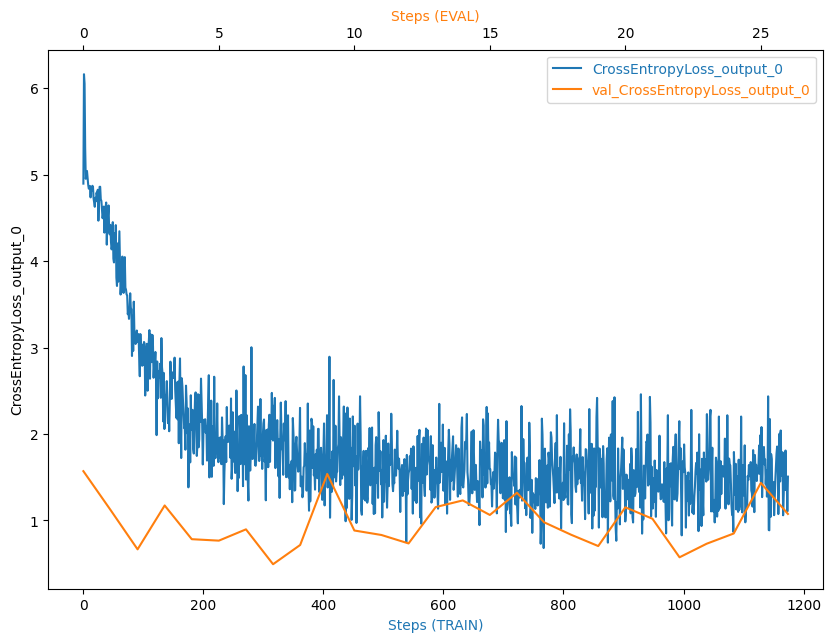

In [29]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


In [3]:
# Display the profiler out
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/debug-output"
print(f"You will find the profiler report in {rule_output_path}")

NameError: name 'estimator' is not defined

In [31]:
! aws s3 ls {rule_output_path} --recursive


2023-05-01 01:09:42          0 pytorch-training-2023-05-01-01-07-11-108/debug-output/claim.smd
2023-05-01 01:09:47       5302 pytorch-training-2023-05-01-01-07-11-108/debug-output/collections/000000000/worker_0_collections.json
2023-05-01 01:09:47 1231043413 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/000000000000/000000000000_worker_0.tfevents
2023-05-01 01:09:49         99 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/000000000001/000000000001_worker_0.tfevents
2023-05-01 01:09:52         99 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/000000000002/000000000002_worker_0.tfevents
2023-05-01 01:09:55         99 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/000000000003/000000000003_worker_0.tfevents
2023-05-01 01:09:57         99 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/000000000004/000000000004_worker_0.tfevents
2023-05-01 01:09:59         99 pytorch-training-2023-05-01-01-07-11-108/debug-output/events/

## Model Deploying

In [32]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [33]:
model_location=estimator.model_data
# model_location = "s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/output/model.tar.gz"
print(model_location)

s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-01-01-07-11-108/output/model.tar.gz


In [34]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=sagemaker.get_execution_role(), 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [35]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Creating model with name: pytorch-inference-2023-05-01-02-01-06-544
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-05-01-02-01-07-180
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-05-01-02-01-07-180


-----!

In [36]:
# TODO: Run an prediction on the endpoint

with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)



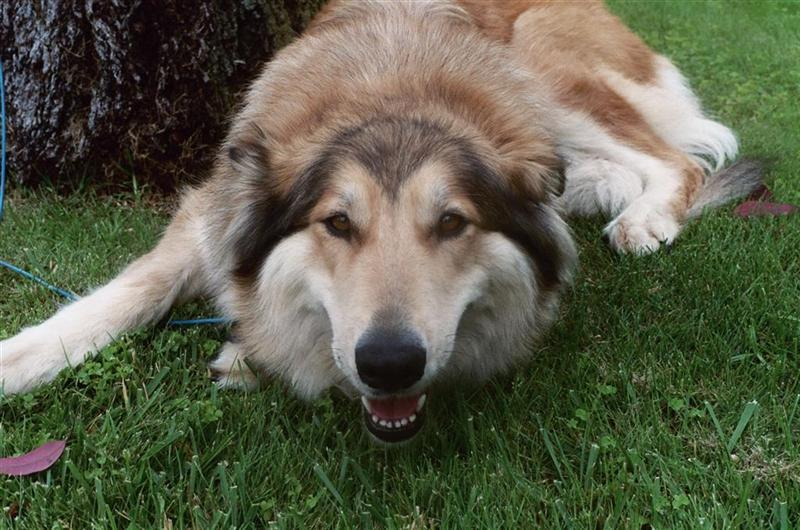

In [37]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [39]:
response = predictor.predict(img_bytes)

In [40]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-23.69508171081543, -9.41038703918457, -24.17951011657715, -8.647419929504395, -6.366016864776611, -17.018449783325195, -8.939189910888672, -14.001023292541504, -19.23723793029785, -5.981754779815674, -5.75615119934082, -1.445427656173706, -15.00229549407959, -12.50689697265625, -15.205920219421387, -10.56710147857666, -14.002628326416016, -10.0973482131958, -29.036012649536133, -8.932374000549316, -13.386700630187988, -9.181894302368164, -8.738120079040527, -31.05462074279785, -21.19167137145996, -28.121885299682617, -16.02764320373535, -25.649518966674805, -3.688882827758789, -14.3699369430542, -7.837984561920166, -22.6768856048584, -24.393672943115234, -16.56221580505371, -15.607069969177246, -17.498937606811523, -5.806797027587891, -12.843992233276367, -18.021997451782227, -19.869020462036133, -22.104700088500977, -19.684226989746094, -4.350650310516357, -16.54856300354004, -3.967608690261841, -9.662787437438965, -16.714303970336914, -11.022993087768555, -1

In [41]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-05-01-02-01-07-180
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-05-01-02-01-07-180
